# AWS SageMaker Tutorial Part 2
https://smusg.udemy.com/course/build-an-aws-machine-learning-pipeline-for-object-detection/learn/lecture/36969246#overview
-	https://github.com/patrikszepesi/EcoAI (MERN app code)
-	https://github.com/patrikszepesi/MachineLearningSourceCodeCourse2 (ML code)


# Collab Shortcuts
Moving / Creating / Deleting
*   move cell up ctrl+m K
*   move cell down ctrl+m J
*   create a new cell above ctrl+m a
*   create a new cell below ctrl+m b
*   delete a cell ctrl+m d

Conversion
*   convert a text cell to code cell ctrl + m + y
*   convert a code cellt o text cell ctrl + m + m (double tap m)

Find and Replace
*   find and replace within cell ctrl + shift + h
*   find and replace within entire notebook ctrl + h

Running code
*   ctrl + enter to run current cell
*   alt + Enter to run current cell and create new cell below
*   ctrl + shift + enter to run selection




```
# ctrl + m + i to interrupt m
# ctrl + m + l to toggle line numbers
# ctrl + m + o to toggle output
print ('1')
```


# Data Loading
Taken from https://storage.googleapis.com/openimages/web/download_v7.html

Loading the data previously downloaded from Part 1

In [2]:
import zipfile
import os

zip_file_paths = ['trainImages.zip', 'valImages.zip']
for path in zip_file_paths:
    with zipfile.ZipFile(path, 'r') as zip_ref:
        # zip_ref.extractall('.')

        # Create unzipped folder containing the same name as the zip file
        name = str(path)
        zip_ref.extractall(f'unzipped/{name.split(".")[0]}')

In [3]:
import pandas as pd

df_train = pd.read_csv('unzipped/trainImages/labels/detections.csv')
df_train.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,...,0,0,0.148438,0.012500,0.059375,0.195312,0.148438,0.357812,0.587500,0.325000
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,...,0,0,0.025000,0.248438,0.276563,0.214062,0.914062,0.714063,0.782813,0.948438
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,...,0,0,0.243750,0.151562,0.310937,0.262500,0.198437,0.434375,0.507812,0.590625
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,...,0,0,0.315625,0.429688,0.256250,0.423438,0.651563,0.921875,0.826562,0.925000
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,...,0,0,0.317188,0.257812,0.346875,0.307812,0.235938,0.289062,0.348438,0.385938


In [4]:
df_val = pd.read_csv('unzipped/valImages/labels/detections.csv')
df_val.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0001eeaf4aed83f9,xclick,/m/0cmf2,1,0.022673,0.964201,0.071038,0.800546,0,0,0,0,0
1,000595fe6fee6369,xclick,/m/02wbm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0
2,000595fe6fee6369,xclick,/m/02xwb,1,0.141384,0.179676,0.676275,0.731707,0,0,0,0,0
3,000595fe6fee6369,xclick,/m/02xwb,1,0.213549,0.253314,0.299335,0.354767,1,0,0,0,0
4,000595fe6fee6369,xclick,/m/02xwb,1,0.232695,0.288660,0.490022,0.545455,1,0,0,0,0


Due to the large size of the csv, switch / use "ml.t3.2xlarge" 8vCPU 32GB memory instance instead of "ml.t3.medium" 2vCPU 4GB (avoid kernel failure / long loading). Be aware this will increase the runtime costs!

For JupyterLab, the space has to be closed before the instance type and resource allocation can be changed. 

In [5]:
print(len(df_train))
print(len(df_val))

14610229
303980


'classes.csv' within Metadata in the trainImages and valImages folders shows which each label correspond to what items / names. The following code checks that the class taxonomy is the same for both training and validation images, specifically for the 'Plastic bag' chosen for this tutorial.

In [6]:
train_class_df = pd.read_csv('unzipped/trainImages/metadata/classes.csv', names=['LabelName', 'Object'])
val_class_df = pd.read_csv('unzipped/valImages/metadata/classes.csv', names=['LabelName', 'Object'])

train_identifier_df = train_class_df[train_class_df['Object'] == 'Plastic bag'] 
val_identifier_df = val_class_df[val_class_df['Object'] == 'Plastic bag'] 

print(f"{train_identifier_df}\n")
print(f"{val_identifier_df}\n")

     LabelName       Object
327  /m/05gqfk  Plastic bag

     LabelName       Object
327  /m/05gqfk  Plastic bag



In [9]:
folder_path_train = 'unzipped/trainImages'
folder_path_val = 'unzipped/valImages'

In [10]:
import glob

def clean_dataframe(df_for_train,df_for_validation):
    # List image files in the train and val folders
    train_images = glob.glob(folder_path_train + '/data/*.jpg')
    val_images = glob.glob(folder_path_val + '/data/*.jpg')
    
    # Extract ImageIDs from the file names
    train_image_ids = {os.path.basename(path)[:16] for path in train_images} # 16 characters before the file extension is the ImageID. Example: '000002b66c9c498e.jpg' from the full file path '/content/drive/My Drive/Colab Notebooks/CS231N Project/data/train/data/000002b66c9c498e.jpg'
    val_image_ids = {os.path.basename(path)[:16] for path in val_images}
    
    # Filter the DataFrames
    df_train_cleansed = df_train[(df_train['LabelName'] == '/m/05gqfk') & (df_train['ImageID'].isin(train_image_ids))]
    df_val_cleansed = df_val[(df_val['LabelName'] == '/m/05gqfk') & (df_val['ImageID'].isin(val_image_ids))]
    
    return df_train_cleansed, df_val_cleansed

df_train_cleansed, df_val_cleansed = clean_dataframe(df_train, df_val)

In [11]:
# def clean_dataframe(df_for_train,df_for_validation):
#     df_train_cleansed = df_train[df_train['LabelName'].str.contains('/m/05gqfk')]
#     df_val_cleansed = df_val[df_val['LabelName'].str.contains('/m/05gqfk')]

#     return df_train_cleansed, df_val_cleansed

# df_train_cleansed, df_val_cleansed = clean_dataframe(df_train, df_val)

In [17]:
print(f"Count of segmentations in train: {len(df_train_cleansed)}")
print(f"Count of segmentations in train: {len(df_val_cleansed)}")

display(df_train_cleansed.head())

Count of segmentations in train: 173
Count of segmentations in train: 9


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
8282,0005a922e055c723,xclick,/m/05gqfk,1,0.000000,0.999375,0.000000,0.998889,0,1,...,0,0,0.546875,0.700000,0.000000,0.999375,0.000000,0.998889,0.000000,0.593333
8733,000610ca2148a5ec,xclick,/m/05gqfk,1,0.163227,0.811445,0.051875,0.936875,0,0,...,0,0,0.740150,0.163227,0.811445,0.811445,0.051875,0.161250,0.936875,0.936875
10247,00075e339f3d4f37,xclick,/m/05gqfk,1,0.017578,0.999023,0.000000,0.998529,0,1,...,0,0,0.263672,0.999023,0.516602,0.017578,0.000000,0.107353,0.998529,0.385294
12496,00097c09aca0cabf,xclick,/m/05gqfk,1,0.112000,0.634000,0.000000,0.909414,1,1,...,0,0,0.355000,0.634000,0.325000,0.112000,0.000000,0.390764,0.909414,0.600355
40914,002c60d5fbc94244,xclick,/m/05gqfk,1,0.375000,0.461250,0.646993,0.772829,0,0,...,0,0,0.433125,0.375000,0.461250,0.457500,0.646993,0.755011,0.766147,0.772829


In [24]:
print(f"Count of unique images in train: {len(set(df_train_cleansed['ImageID']))}")
print(f"Count of unique images in train: {len(set(df_val_cleansed['ImageID']))}")

Count of unique images in train: 100
Count of unique images in train: 9


In [18]:
# Define the directory and file paths
directory = 'unzipped/trainImages/labels'
train_csv_path = os.path.join(directory, 'train_detections.csv')

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the DataFrames to CSV files
df_train_cleansed.to_csv(train_csv_path, index=False)


directory = 'unzipped/valImages/labels'
val_csv_path = os.path.join(directory, 'val_detections.csv')
os.makedirs(directory, exist_ok=True)
df_val_cleansed.to_csv(val_csv_path, index=False)

print(f"Training data saved to {train_csv_path}")
print(f"Validation data saved to {val_csv_path}")

Training data saved to unzipped/trainImages/metadata/train_class.csv
Validation data saved to unzipped/valImages/metadata/val_class.csv


With the classes.csv trimmed, you can switch back to the cheaper "ml.t3.medium" instance. Avoid running the above Data Loading Code and skip to the upcoming section from now on.

# Data Splitting & Preprocessing

In [1]:
folder_path_train = 'unzipped/trainImages'
folder_path_val = 'unzipped/valImages'

In [2]:
import pandas as pd

df_train = pd.read_csv(folder_path_train + '/labels/train_detections.csv')
display(df_train.head())
display(df_train.info())

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0005a922e055c723,xclick,/m/05gqfk,1,0.000000,0.999375,0.000000,0.998889,0,1,...,0,0,0.546875,0.700000,0.000000,0.999375,0.000000,0.998889,0.000000,0.593333
1,000610ca2148a5ec,xclick,/m/05gqfk,1,0.163227,0.811445,0.051875,0.936875,0,0,...,0,0,0.740150,0.163227,0.811445,0.811445,0.051875,0.161250,0.936875,0.936875
2,00075e339f3d4f37,xclick,/m/05gqfk,1,0.017578,0.999023,0.000000,0.998529,0,1,...,0,0,0.263672,0.999023,0.516602,0.017578,0.000000,0.107353,0.998529,0.385294
3,00097c09aca0cabf,xclick,/m/05gqfk,1,0.112000,0.634000,0.000000,0.909414,1,1,...,0,0,0.355000,0.634000,0.325000,0.112000,0.000000,0.390764,0.909414,0.600355
4,002c60d5fbc94244,xclick,/m/05gqfk,1,0.375000,0.461250,0.646993,0.772829,0,0,...,0,0,0.433125,0.375000,0.461250,0.457500,0.646993,0.755011,0.766147,0.772829


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      173 non-null    object 
 1   Source       173 non-null    object 
 2   LabelName    173 non-null    object 
 3   Confidence   173 non-null    int64  
 4   XMin         173 non-null    float64
 5   XMax         173 non-null    float64
 6   YMin         173 non-null    float64
 7   YMax         173 non-null    float64
 8   IsOccluded   173 non-null    int64  
 9   IsTruncated  173 non-null    int64  
 10  IsGroupOf    173 non-null    int64  
 11  IsDepiction  173 non-null    int64  
 12  IsInside     173 non-null    int64  
 13  XClick1X     173 non-null    float64
 14  XClick2X     173 non-null    float64
 15  XClick3X     173 non-null    float64
 16  XClick4X     173 non-null    float64
 17  XClick1Y     173 non-null    float64
 18  XClick2Y     173 non-null    float64
 19  XClick3Y

None

In [3]:
df_val = pd.read_csv(folder_path_val + '/labels/val_detections.csv')
display(df_val.head())
display(df_val.info())

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,1602934b52b119cc,xclick,/m/05gqfk,1,0.000000,1.000000,0.000000,1.00000,1,0,1,0,0
1,488ab15e2780bec9,xclick,/m/05gqfk,1,0.000000,1.000000,0.023599,1.00000,0,0,1,0,0
2,4e24222b68123ef3,xclick,/m/05gqfk,1,0.377083,0.745833,0.778125,0.96875,0,0,0,0,0
3,527bec033e8298a5,xclick,/m/05gqfk,1,0.107813,0.995313,0.106250,0.99375,0,0,0,0,0
4,7e25a4a33611d933,xclick,/m/05gqfk,1,0.000000,1.000000,0.000000,1.00000,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      9 non-null      object 
 1   Source       9 non-null      object 
 2   LabelName    9 non-null      object 
 3   Confidence   9 non-null      int64  
 4   XMin         9 non-null      float64
 5   XMax         9 non-null      float64
 6   YMin         9 non-null      float64
 7   YMax         9 non-null      float64
 8   IsOccluded   9 non-null      int64  
 9   IsTruncated  9 non-null      int64  
 10  IsGroupOf    9 non-null      int64  
 11  IsDepiction  9 non-null      int64  
 12  IsInside     9 non-null      int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 1.0+ KB


None

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size = 0.2, random_state = 42)
display(train.head())
display(test.head())

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
154,09c07b24d4672ea2,xclick,/m/05gqfk,1,0.015000,0.238125,0.607759,0.921336,1,0,...,1,0,0.194375,0.015000,0.161250,0.238125,0.607759,0.766164,0.921336,0.622845
136,079cab48c40308b5,xclick,/m/05gqfk,1,0.668125,0.793125,0.093333,0.303333,1,0,...,0,0,0.725000,0.668125,0.771250,0.793125,0.093333,0.138333,0.303333,0.217500
147,089b1550d7b264b5,xclick,/m/05gqfk,1,0.203333,0.886667,0.185000,0.912500,0,0,...,0,0,0.216667,0.203333,0.881667,0.886667,0.185000,0.912500,0.876875,0.220625
51,011d3ecef79d91ad,activemil,/m/05gqfk,1,0.292500,0.549375,0.297373,0.960600,-1,-1,...,-1,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
126,073dd5489a8faed7,xclick,/m/05gqfk,1,0.384375,0.468750,0.456250,0.704167,1,0,...,0,0,0.404687,0.384375,0.468750,0.431250,0.456250,0.579167,0.629167,0.704167


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
162,09f9fb6ef25b1eda,activemil,/m/05gqfk,1,0.202614,0.764706,0.264706,0.921569,-1,-1,...,-1,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
42,00dabf1d5d5863ba,xclick,/m/05gqfk,1,0.591250,0.777500,0.263245,0.801324,1,0,...,0,0,0.638750,0.591250,0.777500,0.676250,0.263245,0.412252,0.413907,0.801324
90,03b3f942b2c2b0e8,activemil,/m/05gqfk,1,0.084375,0.334375,0.229167,0.480000,-1,-1,...,-1,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
60,01381a0300454d75,xclick,/m/05gqfk,1,0.603125,0.688750,0.362500,0.434167,1,0,...,0,0,0.665625,0.603125,0.688750,0.641875,0.362500,0.412500,0.424167,0.434167
114,0602604499b9c09d,xclick,/m/05gqfk,1,0.368750,0.676562,0.721120,0.998833,1,0,...,0,0,0.483594,0.368750,0.676562,0.664844,0.721120,0.877480,0.977830,0.998833


In [5]:
train_ids = train["ImageID"].values.tolist()
print("Count of segmentations in train:", len(train_ids))
print("-------------------------------")
test_ids = test["ImageID"].values.tolist()
print("Count of segmentations in test:", len(test_ids))

Count of segmentations in train: 138
-------------------------------
Count of segmentations in test: 35


In [6]:
folder_path_train = 'unzipped/trainImages'
folder_path_test = 'unzipped/testImages'
folder_path_val = 'unzipped/valImages'

In [7]:
import os.path
from os import path

# Create folder for test images
path = folder_path_test
# os.mkdir(path) # will fail if the folder already exists
os.makedirs(path, exist_ok=True)

path = folder_path_test + "/data"
os.makedirs(path, exist_ok=True)

In [8]:
import shutil
import glob

to_loop = 'unzipped/trainImages/data/*.jpg'
folder = glob.glob(to_loop)

new_path = 'unzipped/testImages/data'

# Move / Copy images from train data folder to test. 
# Copy if an image has segmentations in both train and test
# Else simply move the entire image over to test
for path in folder:
    id = path[26:42]
    if ((id in test_ids) and (id in train_ids)):
        shutil.copy(path, f"{new_path}/{id}.jpg")
    elif ((id in test_ids) and (id not in train_ids)):
        shutil.move(path, f"{new_path}/{id}.jpg")

In [9]:
train_images = os.listdir(folder_path_train + '/data')
print(f"There are {len(train_images)} images in {folder_path_train}")

test_images = os.listdir(folder_path_test + '/data')
print(f"There are {len(test_images)} images in {folder_path_test}")

train_test_images = set(train_ids).intersection(test_ids)
print(f"There are {len(train_test_images)} images in both {folder_path_train} and {folder_path_test}")

print(f"{len(train_images)} + {len(test_images)} = {len(train_images) + len(test_images)} images")

There are 87 images in unzipped/trainImages
There are 25 images in unzipped/testImages
There are 12 images in both unzipped/trainImages and unzipped/testImages
87 + 25 = 112 images


## Data Visualisation

In [10]:
folder_path_train = 'unzipped/trainImages'
folder_path_test = 'unzipped/testImages'
folder_path_val = 'unzipped/valImages'

In [11]:
import glob # recursive file search library

folder_paths = [folder_path_train, folder_path_test, folder_path_val]
for folder_path in folder_paths:
    counter = 0
    folder = glob.glob(folder_path + '/data/*.jpg')

    for i in folder:
        counter += 1
    print("There are", counter, "images in", folder_path)

There are 87 images in unzipped/trainImages
There are 25 images in unzipped/testImages
There are 9 images in unzipped/valImages


In [12]:
# Get images ids. The image ids are the names of the images without the extension
train_list_ids = []
val_list_ids = []

def get_ids (split, print_this, to_append_list):
    start, end = 0, 0
    if split == folder_path_train:
        start, end = 26, 42 # get the image name from the 26 to 41 character of the path 'unzipped/trainImages/data/*.jpg'
    elif split == folder_path_val:
        start, end = 24, 40 # get the image name from the 24 to 39 character of the path 'unzipped/valImages/data/*.jpg'
    else:
        raise Exception("Invalid parameter")
    folder = split 
    img_paths = glob.glob(folder + '/data/*.jpg')
    img_ids = to_append_list
    
    for i in img_paths:
        img_ids.append(i[start:end])
    print(len(img_ids))
    print(print_this, img_ids[:5])
    print()

In [13]:
get_ids(folder_path_train, "Train images ids sample: ", train_list_ids)
get_ids(folder_path_val, "Validation images ids sample: ", val_list_ids)

87
Train images ids sample:  ['0b02ca412549020e', '04c620141ea4ca83', '011c2e4461eb1fdc', '0224e7521bba044c', '08a6765baa7c3b1a']

9
Validation images ids sample:  ['ecd5fc22a65b8d32', '1602934b52b119cc', '527bec033e8298a5', '488ab15e2780bec9', '4e24222b68123ef3']



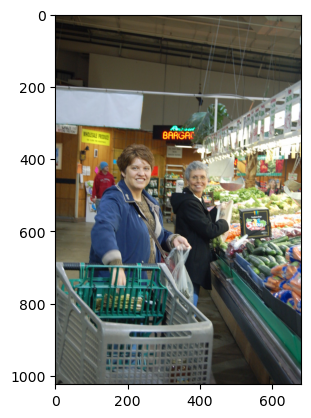

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random

def visualise_random_image(split_name):
    split_path = folder_path_train if split_name == "train" else folder_path_val if split_name == "val" else 0
    if split_path == 0:
        raise Exception("Invalid split name, must be either train or val")
    image_folder = split_path

    image_paths = glob.glob(image_folder + "/data/*.jpg")
    num_of_images = len(image_paths)
    random_int = random.randint(0,num_of_images -1)
    random_image = image_paths[random_int]
    img = mpimg.imread(random_image)
    
    # create the figure and axes and show them
    # plt.imshow() is used to display images, while plt.show() is used to display general plots and figures.
    fig,ax = plt.subplots()
    ax.imshow(img)
    plt.imshow(img)
    plt.show()
    
visualise_random_image("train")

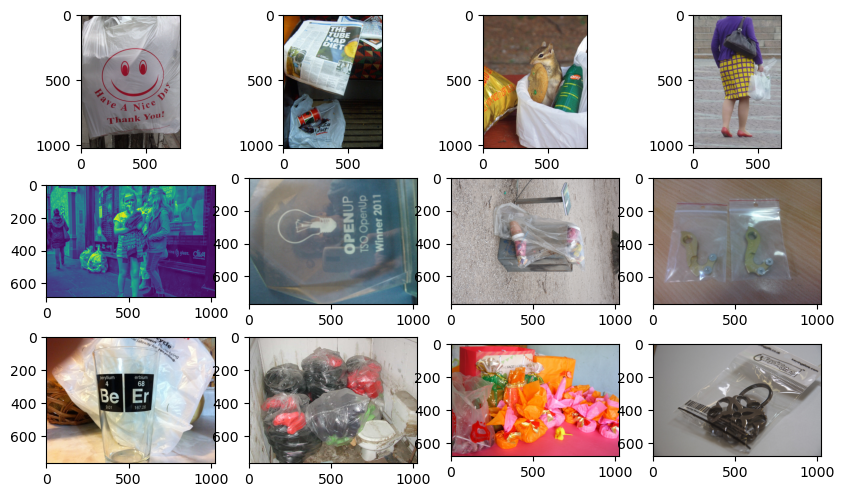

In [15]:
fig = plt.figure(figsize=(10,10))
columns = 4
rows = 5

# validation_images_path = ""#9
# train_images_path = ""#517
                      
def visualize_many(from_num, to_num, split_name):
    dataset_path = folder_path_train if split_name == 'train' else folder_path_val if split_name == 'validation' else 0
    if dataset_path == 0:
        raise Exception("Invalid input parameter, must be either train or validation")
    images_paths = glob.glob(dataset_path + "/data/*.jpg")
    
    index_counter = 1
    for i in range(from_num, to_num):
        counter = i
        image = images_paths[counter]
        img = mpimg.imread(image)
        fig.add_subplot(rows, columns, index_counter)
        plt.imshow(img)
        index_counter +=1
    plt.show()

    
visualize_many(0,12,"train")

0.002667 0.387333 0.188 0.862
2.731008 396.628992 128.404 588.746
0.36 0.658667 0.392 0.999
368.64 674.475008 267.736 682.317
0.52 0.954 0.144 0.999
532.48 976.896 98.35199999999999 682.317


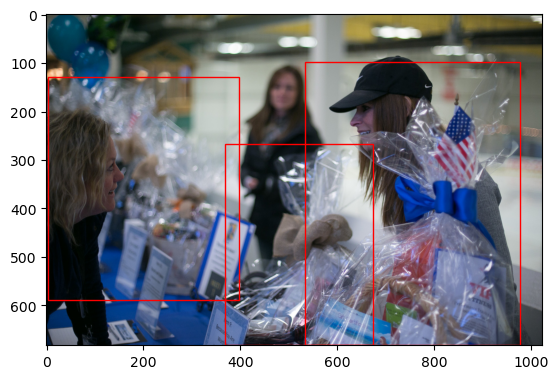

0.0 1.0 0.02359882 1.0
0.0 683.0 24.16519168 1024.0


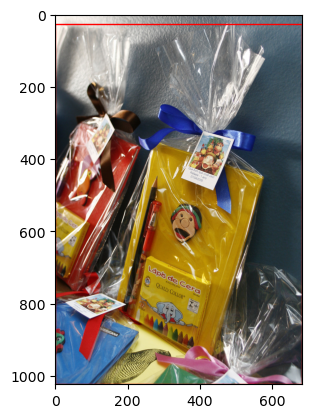

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import random
import glob
from PIL import Image

validation_images_path = ""#9
train_images_path = ""#517


def visualize_bb(dataset):
    folder_path = folder_path_train if dataset == 'train' else folder_path_val if dataset == 'val' else 0
    images_path = folder_path + "/data/*.jpg"
    if dataset == 0:
        raise Exception("Invalid input parameter, must be either train or validation")
    
    start = 0
    end = 0
    
    if dataset == 'train':
        start, end, df, split = 26, 42, df_train, "trainImages"
    elif dataset == 'val':
        start, end, df, split = 24, 40, df_val, "validationImages"
    else:
        raise Exception("Invalid parameter")
    
    image_folder = images_path
    images_paths = glob.glob(image_folder)
    num_of_images = len(images_paths)
    random_int = random.randint(0, num_of_images -1)
    random_image = images_paths[random_int]
    #print(random_image)
    img = Image.open(random_image)
    id_of_image = random_image[start:end]
    
    df_rows = df.loc[(df.ImageID == id_of_image) & (df.LabelName == '/m/05gqfk')]
    
    image_width, image_height = img.size
    
    fig, ax = plt.subplots()
    ax.imshow(img)

    for index, row in df_rows.iterrows():
        print(row['XMin'], row['XMax'], row['YMin'], row['YMax'])
        
        xmin = row['XMin']
        xmax = row['XMax']
        ymin = row['YMin']
        ymax = row['YMax']
        
        new_xmin = xmin * image_width
        new_xmax = xmax * image_width
        new_ymin = ymin * image_height
        new_ymax = ymax * image_height
        print(new_xmin,new_xmax,new_ymin,new_ymax)
        
        width = new_xmax - new_xmin
        height = new_ymax - new_ymin
        
        rect = patches.Rectangle((new_xmin,new_ymin), width, height, linewidth = 1, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
    plt.show()
    
visualize_bb("train")
visualize_bb("val")


# MXNet, RecordIO
Mxnet is an open source deep learning framework that allows you to define, train and deploy deep neural networks on a wide array of devices from cloud infrastructure to mobile devices.

It's highly scalable and it allows for fast model training and supports a flexible programming model and multiple languages. It's similar to TensorFlow, but AWS uses Mxnet for their built-in algorithms as it is faster and integrates better with cloud infrastructure.

RecordIO is a file format for efficiently storing and reading large amounts of binary data, such as images, in a sequential manner. It is used in image processing to enable fast and efficient data access and processing, which is crucial for handling large datasets commonly encountered in machine learning applications. For more Information, refer to https://mesos.apache.org/documentation/latest/recordio/

<b>We'll trimmed the cleaned csv to contain just the relevent columns, then convert them into LST files and then we can convert that into record IOs.</b>

```
# <index> <header_col> <label_width> <class> <xmin> <ymin> <xmax> <ymax> <relative/path/to/image>
# 222 2 5 0.000 0.4 0.3 0.9 0.44 path/to/image11.jpg
# 222 2 5 1.000 0.5 0.2 0.33 0.8 path/to/image11.jpg
```
the header col denotes how RecordIO will take in the upcoming parameters. 2 is set as due to how the "data table" containing 2 headers, the header_col itself and the label_width. Not very essential to understand how it works, but still important to set correctly.

the label width represents the 5 upcoming parameters that will be inputted:
* class
* xmin
* ymin
* xmax
* ymax

0.000 is our chosen plastic bag identifier. So if the algorithm sees an input that has 0.000, it's going to know that it belongs to Plastic bags. 3 decimals is necessary due to how the algorithm is  coded.

0.4, 0.30.90.44 are the bounding box information (xmin, ymin, xmax, ymax)

<center><img src="img/MXNet 00.png"/></center>
<p style="text-align: center">
    <b>Documentation for MXNet</b>
</p><br>

In [5]:
train_df = train.copy()
test_df = test.copy()

In [6]:
train_df.rename(columns = {"LabelName": "className"}, inplace = True)
print(train_df.info())
print(len(train_df))

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 154 to 102
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      138 non-null    object 
 1   Source       138 non-null    object 
 2   className    138 non-null    object 
 3   Confidence   138 non-null    int64  
 4   XMin         138 non-null    float64
 5   XMax         138 non-null    float64
 6   YMin         138 non-null    float64
 7   YMax         138 non-null    float64
 8   IsOccluded   138 non-null    int64  
 9   IsTruncated  138 non-null    int64  
 10  IsGroupOf    138 non-null    int64  
 11  IsDepiction  138 non-null    int64  
 12  IsInside     138 non-null    int64  
 13  XClick1X     138 non-null    float64
 14  XClick2X     138 non-null    float64
 15  XClick3X     138 non-null    float64
 16  XClick4X     138 non-null    float64
 17  XClick1Y     138 non-null    float64
 18  XClick2Y     138 non-null    float64
 19  XClick3Y   

In [7]:
test_df.rename(columns = {"LabelName": "className"}, inplace = True)
print(test_df.info())
print(len(test_df))

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 162 to 115
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      35 non-null     object 
 1   Source       35 non-null     object 
 2   className    35 non-null     object 
 3   Confidence   35 non-null     int64  
 4   XMin         35 non-null     float64
 5   XMax         35 non-null     float64
 6   YMin         35 non-null     float64
 7   YMax         35 non-null     float64
 8   IsOccluded   35 non-null     int64  
 9   IsTruncated  35 non-null     int64  
 10  IsGroupOf    35 non-null     int64  
 11  IsDepiction  35 non-null     int64  
 12  IsInside     35 non-null     int64  
 13  XClick1X     35 non-null     float64
 14  XClick2X     35 non-null     float64
 15  XClick3X     35 non-null     float64
 16  XClick4X     35 non-null     float64
 17  XClick1Y     35 non-null     float64
 18  XClick2Y     35 non-null     float64
 19  XClick3Y    

In [8]:
train_df["ImagePath"] = "001.Plastic_bag/images/train/"+train_df['ImageID']+ '.jpg'
test_df["ImagePath"] = "001.Plastic_bag/images/test/"+test_df['ImageID']+ '.jpg'

In [9]:
train_df = train_df[['className', 'XMin', 'YMin', 'XMax', 'YMax', 'ImagePath']]
test_df = test_df[['className', 'XMin', 'YMin', 'XMax', 'YMax', 'ImagePath']]

In [10]:
pd.set_option("display.precision",4)

final_train_df = train_df.copy()
final_train_df['className'] = "0.000" # Assigning the number 0.000 for our Plastic bag class 

In [11]:
final_test_df = test_df.copy()
final_test_df['className'] = "0.000"

In [12]:
display(final_train_df.head())
display(final_test_df.head())

,className,XMin,YMin,XMax,YMax,ImagePath
154,0.000,0.0150,0.6078,0.2381,0.9213,001.Plastic_bag/images/train/09c07b24d4672ea2.jpg
136,0.000,0.6681,0.0933,0.7931,0.3033,001.Plastic_bag/images/train/079cab48c40308b5.jpg
147,0.000,0.2033,0.1850,0.8867,0.9125,001.Plastic_bag/images/train/089b1550d7b264b5.jpg
51,0.000,0.2925,0.2974,0.5494,0.9606,001.Plastic_bag/images/train/011d3ecef79d91ad.jpg
126,0.000,0.3844,0.4562,0.4688,0.7042,001.Plastic_bag/images/train/073dd5489a8faed7.jpg


,className,XMin,YMin,XMax,YMax,ImagePath
162,0.000,0.2026,0.2647,0.7647,0.9216,001.Plastic_bag/images/test/09f9fb6ef25b1eda.jpg
42,0.000,0.5913,0.2632,0.7775,0.8013,001.Plastic_bag/images/test/00dabf1d5d5863ba.jpg
90,0.000,0.0844,0.2292,0.3344,0.4800,001.Plastic_bag/images/test/03b3f942b2c2b0e8.jpg
60,0.000,0.6031,0.3625,0.6887,0.4342,001.Plastic_bag/images/test/01381a0300454d75.jpg
114,0.000,0.3688,0.7211,0.6766,0.9988,001.Plastic_bag/images/test/0602604499b9c09d.jpg


In [16]:
import os

directory = 'obj_detection/data/001.Plastic_bag/data'
os.makedirs(directory, exist_ok=True)
csv_path = os.path.join(directory, 'final_train_detections.csv')
final_train_df.to_csv(csv_path, index=False)

os.makedirs(directory, exist_ok=True)
csv_path = os.path.join(directory, 'final_test_detections.csv')
final_test_df.to_csv(csv_path, index=False)

## Movios of images for MXNet requirements 

In [35]:
import shutil
shutil.move('unzipped/trainImages/data','obj_detection/data/001.Plastic_bag/images/train')
shutil.move('unzipped/testImages/data','obj_detection/data/001.Plastic_bag/images/test')

'obj_detection/data/001.Plastic_bag/images/test'

In [26]:
# import csv
# import random

## This code is optional. It produces a more production ready .lst doc that abids by MXNet standards for images with multiple segementations being represented by only 1 row.

## Show rows with duplicate image (multiple segmentations within same image
# duplicate_image_paths = final_test_df[final_test_df.duplicated('ImagePath', keep=False)]['ImagePath'].unique()

# first_duplicate_image_path = duplicate_image_paths[0] if len(duplicate_image_paths) > 0 else None
# if first_duplicate_image_path:
#     df_rows_with_first_duplicate = final_test_df.loc[final_test_df['ImagePath'] == first_duplicate_image_path]
# else:
#     df_rows_with_first_duplicate = pd.DataFrame()  # Empty DataFrame if no duplicates found

# display(df_rows_with_first_duplicate)

# final = []
# for id in test_ids:
    
#     df_rows = final_test_df.loc[final_test_df['ImagePath'] == id ]
    
#     im_path = df_rows.loc[df_rows.index[0]]['ImagePath']
    
#     r = random.randint(0,10000000) # set a random value for index. I personally feel should use a incremental counter, to avoid duplicates.
    
#     length = len(df_rows)
#     count = 1
#     arr = [r, 2, 5]
    
#     for index,row in df_rows.iterrows():
#         xmin = str(row['XMin'])
#         ymin = str(row['YMin'])
#         xmax = str(row['XMax'])
#         ymax = str(row['YMax'])
#         #className = str(row['className'])
        
#         arr.extend(["0.000", xmin, ymin, xmax, ymax])
        
#         if count == length:
#             arr.append(im_path)
#         count+=1
        
        
#     final.append(arr)
    
    
# with open('test.lst', 'w', newline = '') as out:
#     for row in final:
#         writer = csv.writer(out, delimiter = '\t')
#         writer.writerow(row)
        

# Data Augmentation
For this project, the image will not be cropped to the bounding box. Hence when transforming the images and their bounding box information to create additional data for the model, 
* for a horizontal flip, the (x & y) min will become the (x & y) max (vice versa)
* for a vertical flip, the x (min & max) will become the y (min and max) (vice versa)

<center><img src="img/augmentation.png"/></center>
<p style="text-align: center">
    <b>Theory for bbox manipulation reflecting across the x / y axis</b>
</p><br>

In [16]:
import os
import pandas as pd

directory = 'obj_detection/data/001.Plastic_bag/data'
# os.makedirs(directory, exist_ok=True)
csv_path = os.path.join(directory, 'final_train_detections.csv')
final_train_df = pd.read_csv(csv_path)

# os.makedirs(directory, exist_ok=True)
csv_path = os.path.join(directory, 'final_test_detections.csv')
final_test_df = pd.read_csv(csv_path)

className                                                  0.0
XMin                                                     0.015
YMin                                                  0.607759
XMax                                                  0.238125
YMax                                                  0.921336
ImagePath    001.Plastic_bag/images/train/09c07b24d4672ea2.jpg
Name: 0, dtype: object

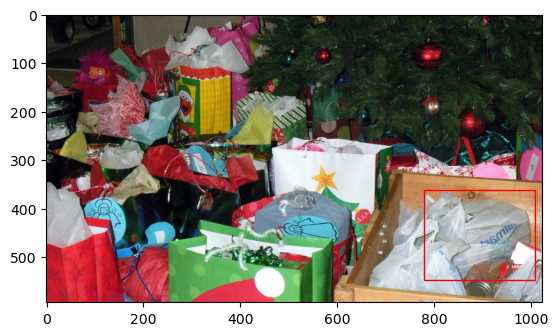

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Example of horizontal flip
example = final_train_df.iloc[0]
display(example)

im = Image.open(str('obj_detection/data/' + example['ImagePath']))
im = im.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

fig, ax = plt.subplots()
ax.imshow(im)

image_width, image_height = im.size
# print(image_width, image_height)

initial_xmin = example['XMin'] * image_width
initial_xmax = example['XMax'] * image_width
ymin = example['YMin'] * image_height
ymax = example['YMax'] * image_height

new_xmin = (image_width/2) - (initial_xmin - (image_width/2))
new_xmax = (image_width/2) - (initial_xmax - (image_width/2))
width = new_xmax - new_xmin
height = ymax - ymin

rect = patches.Rectangle((new_xmin,ymin), width, height, linewidth = 1, edgecolor = 'r', facecolor = 'none')

ax.add_patch(rect)
plt.show()

obj_detection/data/001.Plastic_bag/images/train/00839c7e26f5c5e0.jpg


'00839c7e26f5c5e0'

,className,XMin,YMin,XMax,YMax,ImagePath
20,0.0,0.204698,0.554562,0.375168,0.999106,001.Plastic_bag/images/train/00839c7e26f5c5e0.jpg
49,0.0,0.391275,0.762075,0.554362,0.843470,001.Plastic_bag/images/train/00839c7e26f5c5e0.jpg
114,0.0,0.046980,0.711986,0.183221,0.888193,001.Plastic_bag/images/train/00839c7e26f5c5e0.jpg


0.204698 0.375168 0.554562 0.999106
209.610752 384.172032 425.903616 767.313408
0.391275 0.554362 0.762075 0.84347
400.6656 567.666688 585.2736 647.7849600000001
0.04698 0.183221 0.711986 0.888193
48.10752 187.618304 546.805248 682.132224


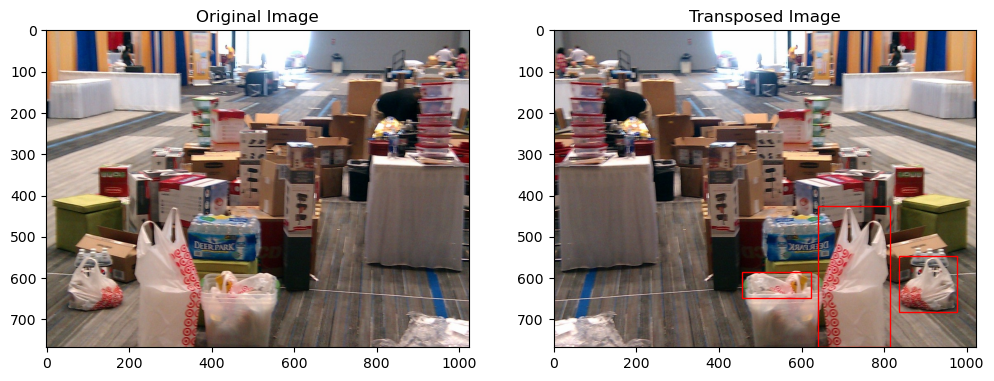

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import random
import glob
from PIL import Image

# Orignally tutorial is PlasticDetection/images/001.Plastic_bag/images/test/00a76046606aa888.jpg
test_images_path = "obj_detection/data/001.Plastic_bag/images/test/*.jpg"
train_images_path = "obj_detection/data/001.Plastic_bag/images/train/*.jpg"

def visualize_transposed_bb(dataset):
    images_path = train_images_path if dataset == 'train' else test_images_path if dataset == 'test' else 0
    if dataset == 0:
        raise Exception("Invalid input parameter, must be either train or validation")
    
    start = 0
    end = 0
    
    if dataset == 'train':
        start, end, df, split = 48, 64, final_train_df, "train" # 16 chracter long + 4 for the extension ".jpg"
    elif dataset == 'test':
        start, end, df, split = 46, 62, final_test_df, "test"
    else:
        raise Exception("Invalid parameter")
    
    image_folder = images_path
    images_paths = glob.glob(image_folder)
    num_of_images = len(images_paths)
    random_int = random.randint(0, num_of_images - 1)
    random_image = images_paths[random_int]
    print(random_image)

    # Load and transpose image (horizontal flip)
    img = Image.open(random_image)
    img_transposed = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
    image_width, image_height = img_transposed.size
    
    id_of_image = random_image[start:end]
    # df_rows = df.loc[(df.ImagePath == f"/{split}/{id_of_image}.jpg") & (df.className == '0.000') ] # Assuming that 0.000 is assigned to the Plastic bag category
    df_rows = df.loc[df.ImagePath.str.contains(f"/{split}/{id_of_image}.jpg")] 
    display(id_of_image)
    display(df_rows)
    # display(df.head())
    
    # fig, ax = plt.subplots()
    # ax.imshow(img)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display original image
    axs[0].imshow(img)
    axs[0].set_title('Original Image')
    
    # Display transposed image
    axs[1].imshow(img_transposed)
    axs[1].set_title('Transposed Image')
    
    for index, row in df_rows.iterrows():
        print(row['XMin'], row['XMax'], row['YMin'], row['YMax'])
        
        xmin = row['XMin']
        xmax = row['XMax']
        ymin = row['YMin']
        ymax = row['YMax']
        
        new_xmin = xmin * image_width
        new_xmax = xmax * image_width
        new_ymin = ymin * image_height
        new_ymax = ymax * image_height
        print(new_xmin, new_xmax, new_ymin, new_ymax)
        
        # flip the bb coordinates
        xmax_flipped = (image_width/2) - (new_xmin-(image_width/2))
        xmin_flipped = (image_width/2) - (new_xmax-(image_width/2))
        width = xmax_flipped - xmin_flipped
        height = new_ymax - new_ymin
        
        rect = patches.Rectangle((xmin_flipped,new_ymin), width, height, linewidth = 1, edgecolor = 'r', facecolor = 'none')
        # ax.add_patch(rect)
        axs[1].add_patch(rect)
    plt.show()
    
visualize_transposed_bb("train")

In [19]:
# test = "001.Plastic_bag/images/test/09f9fb6ef25b1eda.jpg"
# test[28:44]

In [27]:
image_folder_path = "obj_detection/data/001.Plastic_bag/images" 
test_images_path = image_folder_path + "/test/*.jpg"
train_images_path = image_folder_path + "/train/*.jpg"

def augment_data(dataset):
    # images_path = train_images_path if dataset == "train" else test_images_path if dataset == "test" else 0
    # if images_path == 0:
    #     raise Exception("Invalid Input parameter")
    start = 0
    end = 0
    # if dataset == "train":
    #     start,end,df = 29, 45, final_train_df
    # elif dataset == "test":
    #     start,end,df = 28, 44, final_test_df

    if dataset == 'train':
        start, end, df, split = 29, 45, final_train_df, "train" # 16 chracter long + 4 for the extension ".jpg"
    elif dataset == 'test':
        start, end, df, split = 28, 44, final_test_df, "test"
    else:
        raise Exception("Invalid parameter")
    
    temp_df = pd.DataFrame(columns=["header_cols","label_width","className","XMin","YMin","XMax","YMax","ImagePath"],dtype = object)
    counter = 0
    for index,row in df.iterrows():
        img_path = row["ImagePath"] # image path in the df
        id = img_path[start:end]
        im_path = f"{image_folder_path}/{dataset}/{id}.jpg" # image path for the physical location of the image (full path)
        img = Image.open(im_path)
        image_width,image_height = img.size
        img_flip = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

        # Save flipped image 
        img_flip.save(f"{image_folder_path}/{dataset}/flipped_{id}.jpg")
        new_image_path = f"{image_folder_path}/{dataset}/flipped_{id}.jpg"
        
        xmin = row['XMin'] * image_width # XMin is normalised, need to multiply by image_width to get pixel value.
        xmax = row['XMax'] * image_width
        ymin = row['YMin']
        ymax = row['YMax']
        
        # getting the new coordinates for the flipped bounding boxes
        # renormalise min max values for storage
        new_xmin = ((image_width/2)-(xmin-(image_width/2))) / image_width
        new_xmax = ((image_width/2)-(xmax-(image_width/2))) / image_width
        
        temp_df.loc[counter] = [2,5,"0.000", new_xmin, ymin, new_xmax, ymax, new_image_path]
        counter += 1

    # As of pandas 2.0, append (previously deprecated) was removed.
    df_merged = pd.concat([df, temp_df], ignore_index = True)

    df_merged.to_csv(f"{dataset}.lst", sep = "\t", float_format = "%.4f", header = None) # saves files to .lst instead of .csv (smaller, without dataframe capabilities
    print("orignal df length:", len(df)) # original df
    print("augmented df length below:", len(temp_df))
    # print("There should be no difference if the code is working correctly")
    

In [28]:
augment_data("test")

orignal df length: 35
augmented df length below: 35


In [29]:
augment_data("train")

orignal df length: 138
augmented df length below: 138


# Model Training and DevOps
Installation of packages for app development

Leveraging MXnet's "im2rec.py" file from github and copying that into our environment. With that code, we're going to be able to transform our files from test LST and train .lst  into record IO format files.
* Download the python file from https://github.com/apache/mxnet/blob/master/tools/im2rec.py
* Place it into "tools/im2rec.py" from the root folder

<center><img src="img/im2rec.png"/></center>
<p style="text-align: center">
    <b>Create a new "tools" folder beside unzipped and obj_detection folders to place the .py inside.</b>
</p><br>

Running the im2rec.py properly should create 2 files 
* .rec
* .idx (not used in this project) 

In [ ]:
import platform
if platform.linux_distribution()[0] == "debian":
    ! apt-get update
    ! apt-get install ffmpeg libsm6 libxext6 -y

import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install mxnet

In [ ]:
RESIZE_SIZE = 256
BASE_DIR = "obj_detection/"

In [ ]:
# Run the MXnet im2rec.py downloaded and setup beforehand
# obj_detection/data/001.Plastic_bag
!python tools/im2rec.py --resize $RESIZE_SIZE --pack-label test $BASE_DIR/data/

In [ ]:
!python tools/im2rec.py --resize $RESIZE_SIZE --pack-label train $BASE_DIR/data/

Create a S3 bucket at this point, named "aws-sagemaker-tutorial" (bucket names must be lowercase)

In [ ]:
bucket = "aws-sagemaker-tutorial"
prefix = "DEMO-ObjectDetection"

In [ ]:
from sagemaker import get_execution_role
import sagemaker

role = get_execution_role()
sess = sagemaker.Session()

train_channel = prefix + "/train"
sess.upload_data(path= "train.rec", bucket = bucket, key_prefix = train_channel) # Upload data
s3_train_data = "s3://{}/{}".format(bucket,train_channel)
print(s3_train_data) # show us where our train .rec file is

In [ ]:
# Note that in AWS Sagemaker, they coin their validation as tests. In the ML industry, tests data is for fine tuning only, which is what this "validation" is being used for in SageMaker. Hence why we're loading our test data as "validation"
validation_channel = prefix + "/validation"
sess.upload_data(path= "test.rec", bucket = bucket, key_prefix = validation_channel)
s3_validation_data = "s3://{}/{}".format(bucket,validation_channel)
print(s3_validation_data)

In [ ]:
import os
import glob

# Define the .rec and .idx files to delete after uploading to S3
file_patterns = ["*.rec", "*.idx"]
for pattern in file_patterns:``
    for file_path in glob.glob(pattern):
        # Delete the file with matching patterns
        os.remove(file_path)
        print(f"Deleted {file_path}")

In [ ]:
# Define where Sagemaker will output to
s3_output_location =  "s3://{}/{}/output".format(bucket, prefix)
print(s3_output_location)

In [ ]:
from sagemaker import image_uris

training_image = image_uris.retrieve(
    # get AWS object detection model. version="1" indicates the latest ver
    region = sess.boto_region_name, framework = "object-detection", version = "1"
)

print(training_image) # should be an AWS ECR (elastic container registry)

## Set up training job

Link to parameter settings: https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection-api-config.html 

<b>If you don't want to spend money in this course, then I recommend you not training your model because this will cost ~$20 (will be setting up multiple training jobs for hyperparameter tuning).</b>

If you're only going to set up one job, which I'm going to show you guys in an upcoming video, then it's going to be cheaper.

But, you know, I think it's worth getting your hands dirty and spending $20 because that way you really get to interact with sagemaker and know the ins and outs of it.

In [ ]:
# File Mode: Data is copied to the local storage of the training instance. (cheap and more straightforward)
# Pipe Mode: Data is streamed directly from S3 to the training instance.
# Pipe mode is faster and recommended for large datasets. (Needs parquet format, but cheaper and faster)

od_model = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count = 1, # no. of instance for training 
    instance_type = "ml.p3.2xlarge",
    volume_size = 50, # volume size (GB) for storing training input and output data
    max_run = 360000, # training termination limit in seconds (s) 
    input_mode = "File", # 'file' for copying data from S3, 'pipe' for streaming data directly from S3 (needs parquet format)
    output_path = s3_output_location,
    sagemaker_session = sess,)
print(od_model)

In [ ]:
# keeping the early layers of the CNN (avoid wasting time / resources retraining the early layers of edge detection, etc)
# just train / change the final layer to detect our desired object

def set_hyperparameters(num_epochs, lr_steps):
    num_classes = 1 # since only Plastic bag for this project
    num_training_samples = 898
    
    od_model.set_hyperparameters(
        base_network = "resnet-50", # can use 'VGG-16' as well
        use_pretrained_model = 1, # sets True for transfer learning (use existing pretrained weights)
        num_classes = num_classes,
        epochs = num_epochs,
        lr_scheduler_step = lr_steps,
        lr_scheduler_factor = 0.1,
        momentum = 0.9, # prevents overfitting (overcome local minima and smooth out the learning process by adding part of previous weight update to the next step)
        weight_decay = 0.0005,
        nms_threshold = 0.45, # non-maximum suppression threshold (remove low confidence bounding boxes)
        image_shape = 512,
        num_training_samples = 898 
    )
set_hyperparameters(100, "50,70,80,90,95") # total 100 epochs, learning rate decreases/decay at epoch 50,70,80,90,95

In [ ]:
# Default hyperparameterthe default value for AWS is Bayesian search (learns from previous hyper parameter tuning jobs.)

from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001,0.1), # continuous values from 0.001 to 0.1
    "mini_batch_size": CategoricalParameter([8,16]), # batch size (reduce memory load needed). Balance between noise (batch_size = 1) and memory load (entire batch gradient desc)
    "optimizer": CategoricalParameter(["sgd","adam"])
}

max_jobs = 1 # No. of training jobs ($$$) Tutorial suggest min. 3. Go for 8 for good tuning.
max_parallel_jobs = 1
objective_metric_name = "validation:mAP" # REMEMER WE'RE USING TEST DATA (SAGEMAKER CALLS THIS VALIDATION)
objective_type = "Maximize"

tuner = HyperparameterTuner(estimator = od_model,
                            objective_metric_name = objective_metric_name,
                            hyperparameter_ranges = hyperparameter_ranges,
                            objective_type = objective_type,
                            max_jobs = max_jobs,
                            max_parallel_jobs = max_parallel_jobs          
                           )